In [1]:
# importing the necessary libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE 
from scipy import stats as stats
from imblearn.pipeline import Pipeline as imbpipe
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,confusion_matrix,\
roc_curve,roc_auc_score,classification_report, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from scipy.stats import randint
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

#### DATA UNDERSTANDING

Load the dataset

In [2]:
# Load the data into a dataframe and read the first five rows
df = pd.read_csv('combined_dta.csv', encoding='ISO-8859-1')

df.head()

,web-scraper-order,web-scraper-start-url,product,product-href,product_name,image,price,brand,link,link-href,see_all,see_all-href,review_title,review,ratings,user_name,date,see_all_link,see_all_link-href,Category
0,1730407108-1,https://www.jumia.co.ke/computer-accessories/,Black Friday dealLaptop Skin Wrap Vinyl from 1...,https://www.jumia.co.ke/generic-laptop-skin-wr...,Laptop Skin Wrap Vinyl from 12-17.0 inches Lap...,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,KSh 699 - KSh 797,NaN,NaN,https://www.jumia.co.ke/computer-accessories/?...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Computing
1,1730407112-2,https://www.jumia.co.ke/computer-accessories/,"Black Friday deal9""-17"" Laptop Cooling Stand P...",https://www.jumia.co.ke/9-17-laptop-cooling-st...,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,"KSh 3,325",NaN,NaN,https://www.jumia.co.ke/computer-accessories/?...,See All,https://www.jumia.co.ke/catalog/productratings...,OKAY,"Working, feels cheap",3 out of 5,by WILFRED,28/04/2022,NaN,NaN,Computing
2,1730407112-3,https://www.jumia.co.ke/computer-accessories/,"Black Friday deal9""-17"" Laptop Cooling Stand P...",https://www.jumia.co.ke/9-17-laptop-cooling-st...,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,"KSh 3,325",NaN,NaN,https://www.jumia.co.ke/computer-accessories/?...,See All,https://www.jumia.co.ke/catalog/productratings...,okay,A bit big for a regular laptop bag... The fanc...,4 out of 5,by Michael,8/7/2021,NaN,NaN,Computing
3,1730407114-4,https://www.jumia.co.ke/computer-accessories/,"Black Friday dealLexar 2.5"" SATA 256GB Laptop ...",https://www.jumia.co.ke/lexar-2.5-sata-256gb-l...,"Lexar 2.5"" SATA 256GB Laptop SSD",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,"KSh 3,799",Lexar,NaN,https://www.jumia.co.ke/computer-accessories/?...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Computing
4,1730407116-5,https://www.jumia.co.ke/computer-accessories/,"WD External Portable Hard Drive-2TBKSh 15,000",https://www.jumia.co.ke/wd-external-portable-h...,WD External Portable Hard Drive-2TB,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,"KSh 15,000",WD,NaN,https://www.jumia.co.ke/computer-accessories/?...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Computing


In [3]:
# Check the number of rows and columns in the dataset
df.shape

(60464, 20)

In [4]:
# List of columns in the dataset
df.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'product', 'product-href',
       'product_name', 'image', 'price', 'brand', 'link', 'link-href',
       'see_all', 'see_all-href', 'review_title', 'review', 'ratings',
       'user_name', 'date', 'see_all_link', 'see_all_link-href', 'Category'],
      dtype='object')

In [5]:
#Check the data types and the non-null count of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60464 entries, 0 to 60463
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   web-scraper-order      60464 non-null  object
 1   web-scraper-start-url  60464 non-null  object
 2   product                60464 non-null  object
 3   product-href           60464 non-null  object
 4   product_name           60459 non-null  object
 5   image                  60330 non-null  object
 6   price                  60330 non-null  object
 7   brand                  39584 non-null  object
 8   link                   28139 non-null  object
 9   link-href              36020 non-null  object
 10  see_all                40431 non-null  object
 11  see_all-href           40425 non-null  object
 12  review_title           37705 non-null  object
 13  review                 40201 non-null  object
 14  ratings                37618 non-null  object
 15  user_name          

#### DATA CLEANING

In [6]:
# Function to calculate the percentage of null values in every column

def null_percentages(df):
    
    # Calculate the number of missing values and their percentage
    null_values = df.isnull().sum()
    null_percentage = (null_values / df.shape[0]) * 100
    
    # Create a DataFrame with the results
    missing_data = pd.DataFrame({'Null Values': null_values, 'Percentage': null_percentage})

    # Filter out columns with no missing values and sort by 'Missing Values'
    missing_data = missing_data[missing_data['Null Values'] > 0].sort_values(by='Null Values', ascending=False)

    return missing_data

In [7]:
null_percentages(df)

,Null Values,Percentage
see_all_link,60413,99.915652
see_all_link-href,60413,99.915652
link,32325,53.461564
link-href,24444,40.427362
ratings,22846,37.784467
user_name,22846,37.784467
date,22846,37.784467
review_title,22759,37.640580
brand,20880,34.532945
review,20263,33.512503


In [8]:
# Drop the columns with more than 75% null values
def drop_null_columns(df, threshold=75):
   # Calculate the percentage of null values in each column

   null_percentages = (df.isnull().sum() / len(df)) * 100

   # Identify columns to drop

   columns_to_drop = null_percentages[null_percentages > threshold].index

   # Drop the identified columns
   df = df.drop(columns=columns_to_drop, axis=1)
    
   return df

In [9]:
df_1 = drop_null_columns(df)

df_1.shape

(60464, 18)

In [10]:
df_1.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'product', 'product-href',
       'product_name', 'image', 'price', 'brand', 'link', 'link-href',
       'see_all', 'see_all-href', 'review_title', 'review', 'ratings',
       'user_name', 'date', 'Category'],
      dtype='object')

In [11]:
# check null values in the new dataset
null_percentages(df_1)

,Null Values,Percentage
link,32325,53.461564
link-href,24444,40.427362
ratings,22846,37.784467
user_name,22846,37.784467
date,22846,37.784467
review_title,22759,37.640580
brand,20880,34.532945
review,20263,33.512503
see_all-href,20039,33.142035
see_all,20033,33.132112


In [12]:
# Impute Missing Values in URL-Related Columns
df_1['link'].fillna('No Link', inplace=True)
df_1['link-href'].fillna('No Link', inplace=True)
df_1['see_all'].fillna('No Link', inplace=True)
df_1['see_all-href'].fillna('No Link', inplace=True)

In [13]:
# Impute less critical columns
df_1['brand'].fillna('Unknown', inplace=True)
df_1['review_title'].fillna('No Title', inplace=True)

In [14]:
# For the price column, some of the prices are a range and the column also
# includes strings with currency symbol (Ksh)i.e.:
df_1['price']

0        KSh 699 - KSh 797
1                KSh 3,325
2                KSh 3,325
3                KSh 3,799
4               KSh 15,000
               ...        
60459              KSh 675
60460              KSh 499
60461    KSh 570 - KSh 751
60462              KSh 383
60463              KSh 383
Name: price, Length: 60464, dtype: object

In [15]:
# Function to remove the currency and calculate the average of the price range
import re

def convert_price(price):
    # Remove non-numeric characters (i.e.currency symbols)
    cleaned_price = re.sub(r"[^\d.-]", "", str(price))
    
    # Handle ranges
    if '-' in cleaned_price:
        try:
            low, high = map(float, cleaned_price.split('-'))
            return (low + high) / 2
        except ValueError:
            return None  # Return None if conversion fails
    else:
        try:
            return float(cleaned_price)  # Convert single prices to float
        except ValueError:
            return None

In [16]:
# Apply the conversion function to the price column
df_1['price'] = df_1['price'].apply(convert_price)

In [17]:
# Fill remaining null values with the median(to retain more data)
df_1['price'].fillna(df_1['price'].median(), inplace=True)

In [18]:
# check null values in the cleaned dataset
null_percentages(df_1)

,Null Values,Percentage
ratings,22846,37.784467
user_name,22846,37.784467
date,22846,37.784467
review,20263,33.512503
image,134,0.221619
product_name,5,0.008269


In [19]:
# The ratings column contains string values (i.e. '3 out of 5')
df_1['ratings']

0               NaN
1        3 out of 5
2        4 out of 5
3               NaN
4               NaN
            ...    
60459           NaN
60460    4 out of 5
60461           NaN
60462    3 out of 5
60463    5 out of 5
Name: ratings, Length: 60464, dtype: object

In [20]:
# Function to extract numeric rating from a string
def extract_rating(rating):
    match = re.search(r'\d+', str(rating))  # Finding the first digit in the string
    if match:
        return float(match.group())  # Convert the first digit to float
    return None  # Return None if no digit is found 

In [21]:
# Apply the function to the ratings column
df_1['ratings'] = df_1['ratings'].apply(extract_rating)

In [22]:
# Get the distribution of non-null ratings (Rather than filling in missing values with the majority class or a simple average, sample from the existing ratings in a way that maintains a balanced distribution.)
ratings_dist = df_1['ratings'].value_counts(normalize=True)

# Impute missing ratings by sampling from the existing distribution
df_1['ratings'] = df_1['ratings'].apply(lambda x: np.random.choice(ratings_dist.index, p=ratings_dist.values) if pd.isnull(x) else x)


In [23]:
# Fill missing ratings with the mode rating per product(different products have varying ratings, impute missing ratings by the most common rating (mode) for each product.)
#df['ratings'] = df.groupby('product')['ratings'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 5))


In [24]:
# Review: Impute with placeholder(to retain more data)
df_1['review'].fillna('No Review', inplace=True)

In [25]:
# User name: Impute with placeholder(to retain more data)
df_1['user_name'].fillna('Anonymous', inplace=True)

In [26]:
# Covert date to datetime
df_1['date'] = pd.to_datetime(df_1['date'], errors='coerce')
# Create separate columns for day, month, and year
df_1['day'] = df_1['date'].dt.day
df_1['month'] = df_1['date'].dt.month
df_1['year'] = df_1['date'].dt.year

In [27]:
# Drop date column as it is no longer necessary
df_1.dropna(subset=['date'], inplace=True)

In [28]:
# Date: Impute day with the 1st of the month
df_1['day'].fillna(1, inplace=True)
# Impute month with the most common month (mode)
df_1['month'].fillna(df_1['month'].mode()[0], inplace=True)
# Impute year with the most frequent year in the dataset
df_1['year'].fillna(df_1['year'].mode()[0], inplace=True)

In [29]:
# Image: Impute with placeholder (because image will be needed for deployment)
df_1['image'].fillna('No Image Available', inplace=True)

In [30]:
# Product name: Impute with placeholder (to retain more data)
df_1['product_name'].fillna('Unknown Product', inplace=True)

In [31]:
# check null values in the cleaned dataset
null_percentages(df_1)

,Null Values,Percentage


In [32]:
df_1.head()

,web-scraper-order,web-scraper-start-url,product,product-href,product_name,image,price,brand,link,link-href,...,see_all-href,review_title,review,ratings,user_name,date,Category,day,month,year
1,1730407112-2,https://www.jumia.co.ke/computer-accessories/,"Black Friday deal9""-17"" Laptop Cooling Stand P...",https://www.jumia.co.ke/9-17-laptop-cooling-st...,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3325.0,Unknown,No Link,https://www.jumia.co.ke/computer-accessories/?...,...,https://www.jumia.co.ke/catalog/productratings...,OKAY,"Working, feels cheap",3.0,by WILFRED,2022-04-28,Computing,28.0,4.0,2022.0
2,1730407112-3,https://www.jumia.co.ke/computer-accessories/,"Black Friday deal9""-17"" Laptop Cooling Stand P...",https://www.jumia.co.ke/9-17-laptop-cooling-st...,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3325.0,Unknown,No Link,https://www.jumia.co.ke/computer-accessories/?...,...,https://www.jumia.co.ke/catalog/productratings...,okay,A bit big for a regular laptop bag... The fanc...,4.0,by Michael,2021-07-08,Computing,8.0,7.0,2021.0
29,1730407173-30,https://www.jumia.co.ke/computer-accessories/,Black Friday dealToshiba High Speed Micro SD M...,https://www.jumia.co.ke/toshiba-high-speed-mic...,Toshiba High Speed Micro SD Memory Card,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,803.0,Toshiba,No Link,https://www.jumia.co.ke/computer-accessories/?...,...,https://www.jumia.co.ke/catalog/productratings...,good,genuine,4.0,by your name,2021-11-29,Computing,29.0,11.0,2021.0
30,1730407177-31,https://www.jumia.co.ke/computer-accessories/,Black Friday dealLenovo Laptop Charger For Len...,https://www.jumia.co.ke/laptop-charger-for-len...,Lenovo Laptop Charger For Lenovo ThinkPad Yoga...,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,4157.0,Lenovo,No Link,https://www.jumia.co.ke/computer-accessories/?...,...,https://www.jumia.co.ke/catalog/productratings...,I like it,It worked out well,1.0,by Bathsheba,2020-10-31,Computing,31.0,10.0,2020.0
37,1730407197-38,https://www.jumia.co.ke/computer-accessories/,"Black Friday dealSafaricom, Airtel & Telkom -4...",https://www.jumia.co.ke/safaricom-airtel-telko...,"Safaricom, Airtel & Telkom -4G/3G Universal Modem",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,2600.0,Unknown,No Link,https://www.jumia.co.ke/computer-accessories/?...,...,https://www.jumia.co.ke/catalog/productratings...,Works well,So far so good...,5.0,by Ngarachu,2024-06-11,Computing,11.0,6.0,2024.0


In [33]:
# Extract the sub-category from the URL and create a new column
df_1['subcategory'] = df_1['web-scraper-start-url'].apply(lambda x: x.rstrip('/').split('/')[-1])
df_1 ['subcategory']

1           computer-accessories
2           computer-accessories
29          computer-accessories
30          computer-accessories
37          computer-accessories
                  ...           
60440    aromatherapy-fragrances
60450    aromatherapy-fragrances
60452    aromatherapy-fragrances
60454    aromatherapy-fragrances
60460    aromatherapy-fragrances
Name: subcategory, Length: 31013, dtype: object

In [34]:
# Remove the "by " prefix from the start of each username
df_1['user_name'] = df_1['user_name'].str.replace(r'^by\s+', '', regex=True)

In [35]:
# Extract the overall ratings and ratings count
df['overall_ratings'] = df['product'].str.extract(r'(\d+(\.\d+)?) out of 5')[0]
df['ratings_count'] = df['product'].str.extract(r'(\d+) out of 5\((\d+)\)')[1].astype(float)

print(df[['overall_ratings', 'ratings_count']])

      overall_ratings  ratings_count
0                 NaN            NaN
1                 4.1            7.0
2                 4.1            7.0
3                 NaN            NaN
4                 NaN            NaN
...               ...            ...
60459             NaN            NaN
60460               4            5.0
60461             NaN            NaN
60462             3.5            8.0
60463             3.5            8.0

[60464 rows x 2 columns]


In [36]:
df_1.head()

,web-scraper-order,web-scraper-start-url,product,product-href,product_name,image,price,brand,link,link-href,...,review_title,review,ratings,user_name,date,Category,day,month,year,subcategory
1,1730407112-2,https://www.jumia.co.ke/computer-accessories/,"Black Friday deal9""-17"" Laptop Cooling Stand P...",https://www.jumia.co.ke/9-17-laptop-cooling-st...,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3325.0,Unknown,No Link,https://www.jumia.co.ke/computer-accessories/?...,...,OKAY,"Working, feels cheap",3.0,WILFRED,2022-04-28,Computing,28.0,4.0,2022.0,computer-accessories
2,1730407112-3,https://www.jumia.co.ke/computer-accessories/,"Black Friday deal9""-17"" Laptop Cooling Stand P...",https://www.jumia.co.ke/9-17-laptop-cooling-st...,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3325.0,Unknown,No Link,https://www.jumia.co.ke/computer-accessories/?...,...,okay,A bit big for a regular laptop bag... The fanc...,4.0,Michael,2021-07-08,Computing,8.0,7.0,2021.0,computer-accessories
29,1730407173-30,https://www.jumia.co.ke/computer-accessories/,Black Friday dealToshiba High Speed Micro SD M...,https://www.jumia.co.ke/toshiba-high-speed-mic...,Toshiba High Speed Micro SD Memory Card,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,803.0,Toshiba,No Link,https://www.jumia.co.ke/computer-accessories/?...,...,good,genuine,4.0,your name,2021-11-29,Computing,29.0,11.0,2021.0,computer-accessories
30,1730407177-31,https://www.jumia.co.ke/computer-accessories/,Black Friday dealLenovo Laptop Charger For Len...,https://www.jumia.co.ke/laptop-charger-for-len...,Lenovo Laptop Charger For Lenovo ThinkPad Yoga...,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,4157.0,Lenovo,No Link,https://www.jumia.co.ke/computer-accessories/?...,...,I like it,It worked out well,1.0,Bathsheba,2020-10-31,Computing,31.0,10.0,2020.0,computer-accessories
37,1730407197-38,https://www.jumia.co.ke/computer-accessories/,"Black Friday dealSafaricom, Airtel & Telkom -4...",https://www.jumia.co.ke/safaricom-airtel-telko...,"Safaricom, Airtel & Telkom -4G/3G Universal Modem",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,2600.0,Unknown,No Link,https://www.jumia.co.ke/computer-accessories/?...,...,Works well,So far so good...,5.0,Ngarachu,2024-06-11,Computing,11.0,6.0,2024.0,computer-accessories


In [37]:
df_1.shape

(31013, 22)

#### Exploratory Data Analysis

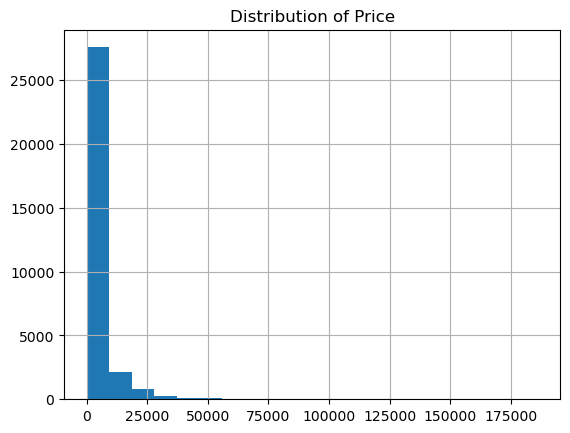

In [58]:
# Histogram for numerical columns
df_1['price'].hist(bins=20)
plt.title('Distribution of Price')
plt.show()

In [60]:
# Since price is positively skewed, 
# Calculate IQR to detect outliers
Q1 = df_1['price'].quantile(0.25)
Q3 = df_1['price'].quantile(0.75)
IQR = Q3 - Q1
threshold = Q3 + 1.5 * IQR

# Identify outliers
outliers = df_1[df_1['price'] > threshold]
print("Number of outliers:", len(outliers))
print(outliers[['product_name', 'price']].sort_values(by='price', ascending=False))

Number of outliers: 5149
                                            product_name     price
42858  LG 75UP7760 75" UHD 4K HDR WebOS Smart AI Thin...  186000.0
50079  Ramtons RF/265 - 527L Side By Side LED Fridge ...  149300.0
51057  Ramtons RW/153- 12KG Front Load Washing Machin...   93500.0
50001  Samsung RT28K3082S8 Top Mount Freezer Refriger...   92999.0
1998   HP Envy X360 15 11th Gen Core i7 16GB RAM 512G...   90000.0
...                                                  ...       ...
27195     Samsung GM-B311V Flip 2Inch Dual Sim 1.3MP-Red    4749.0
27034                SIMI S502 - 5."  HD + 1GB And 16GB.    4749.0
27027                SIMI S502 - 5."  HD + 1GB And 16GB.    4749.0
27028                SIMI S502 - 5."  HD + 1GB And 16GB.    4749.0
27035                SIMI S502 - 5."  HD + 1GB And 16GB.    4749.0

[5149 rows x 2 columns]


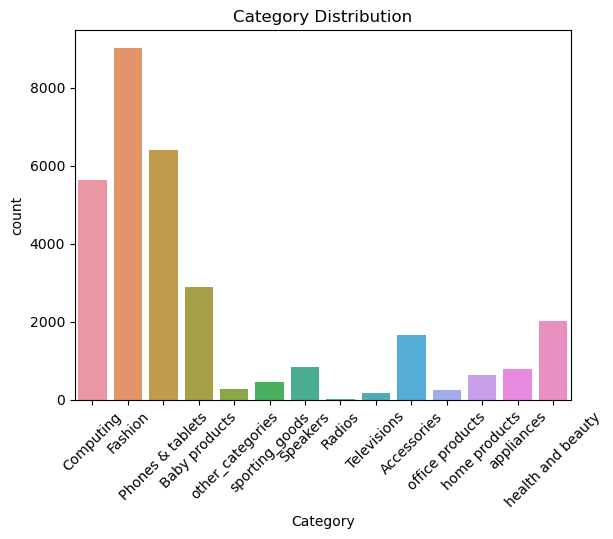

In [59]:
# Bar plot for categorical data
sns.countplot(data=df_1, x='Category')
plt.title('Category Distribution')
plt.xticks(rotation=45)
plt.show()

In [38]:
# Analyze the distribution of items across different subcategories
subcategory_counts = df_1['subcategory'].value_counts()
subcategory_counts

subcategory
mobile-phones               1336
#catalog-listing            1126
mobile-accessories           986
?price=0-1000                838
computer-accessories         803
                            ... 
outdoor-decor                  1
biography-autobiography        1
education-learning-books       1
skin-care-sets-kits            1
kettles                        1
Name: count, Length: 193, dtype: int64

In [40]:
# Filtering subcategories with a higher count for easier analysis
popular_subcategories = df_1['subcategory'].value_counts()[df_1['subcategory'].value_counts() > 100].index
df_1_popular = df_1[df_1['subcategory'].isin(popular_subcategories)]

In [41]:
# Group rare subcategories as "Other"
df_1['subcategory'] = df_1['subcategory'].apply(lambda x: x if df_1['subcategory'].value_counts()[x] > 5 else 'Other')

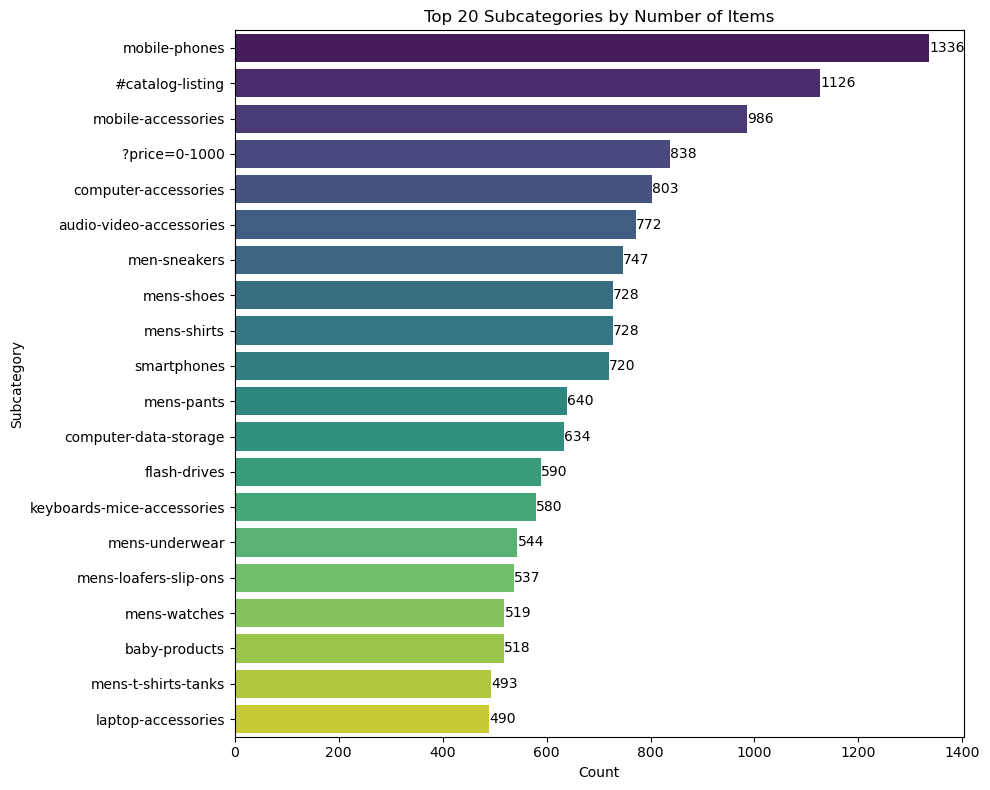

In [43]:
# Bar Plot for Subcategory Count to get a sense of distribution
# Sort subcategories in descending order and select the top 20
subcategory_counts = df_1['subcategory'].value_counts().head(20)

plt.figure(figsize=(10, 8))
sns.barplot(
    y=subcategory_counts.index,
    x=subcategory_counts.values,
    palette="viridis"
)
plt.xlabel("Count")
plt.ylabel("Subcategory")
plt.title("Top 20 Subcategories by Number of Items")

# Adding value annotations
for index, value in enumerate(subcategory_counts.values):
    plt.text(value, index, str(value), va='center')  # Adding values next to bars

plt.tight_layout()
plt.show()

In [44]:
# average ratings and prices for each subcategory
subcategory_stats = df_1.groupby('subcategory').agg({
    'ratings': 'mean',
    'price': 'mean'
}).sort_values(by='ratings', ascending=False)
print(subcategory_stats)

                                           ratings        price
subcategory                                                    
sports-endurance-energy-supplements       4.857143  2432.142857
sports-endurance-energy-endurance-energy  4.857143  2432.142857
christian-books-bibles                    4.722222  1446.722222
skin-care-lotions                         4.720430   864.134409
hair-shampoos-d                           4.690476  1044.071429
...                                            ...          ...
internal-phone-batteries                  3.325758  2025.590909
womens-skirts                             3.323529   622.367647
mens-hair-loss-treatments-d               3.285714  1198.959184
automobile-lights-lighting-accessories    3.238095  1205.452381
sports-nutrition-weight-gainers           3.100000  1804.400000

[177 rows x 2 columns]


In [ ]:
# Initialize encoder
encoder = OneHotEncoder(sparse_output=True)

# Apply encoding only to categorical columns
encoded_columns = encoder.fit_transform(df_1[['Category', 'brand']])

# Convert the result to a DataFrame and concatenate with the original DataFrame
encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_columns, columns=encoder.get_feature_names_out(['Category', 'brand']))
df_1 = pd.concat([df_1, encoded_df], axis=1).drop(columns=['Category', 'brand'])